In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import pandas as pd
import numpy as np
import scipy as sp
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
import seaborn as sns

import kinesis as kn
import gapipes as gp

kn.set_mpl_style()

In [4]:
# %load ../scripts/estimate-cluster-center.py
df = pd.read_csv("../data/hyades_full.csv")
cl_gaia = df.loc[df["in_dr2"] == True].copy()


def xyz_icrs_to_galactic(xyz):
    c = coord.ICRS(*xyz, representation_type="cartesian")
    return c.transform_to(coord.Galactic).cartesian.xyz.value


b_c_icrs_cl_gaia_mean = cl_gaia.g.icrs.cartesian.xyz.mean(axis=1)
b_c_galactic_cl_gaia_mean = xyz_icrs_to_galactic(b_c_icrs_cl_gaia_mean)

xyz = df.g.icrs.cartesian.xyz.value
in_10pc = [np.ones(xyz.shape[1]).astype(bool)]
r_cut = 10  # pc, radius cut
niter = 10  # maximum number of iteration
for i in range(niter):
    print(i)
    prev = in_10pc[-1]
    b_c = xyz[:, prev].mean(axis=1)
    r_c = np.linalg.norm(xyz - b_c[:, None], axis=0)
    current = r_c < r_cut
    if (current == prev).all():
        print("membership converged")
        break
    else:
        in_10pc.append(current)

b_c_icrs_cl_gaia_iter_mean = b_c
r_c = np.linalg.norm(xyz - b_c_icrs_cl_gaia_iter_mean[:, None], axis=0)
n_r_cut = (r_c < r_cut).sum()

n_r_cut_p05 = (r_c < r_cut + 0.5).sum()
n_r_cut_m05 = (r_c < r_cut - 0.5).sum()
print(b_c_icrs_cl_gaia_iter_mean)
print(n_r_cut, n_r_cut_p05, n_r_cut_m05)


b_c_gal = np.array([-44.16, 0.66, -17.76])  # pc
b_c_gal_err = np.array([0.74, 0.39, 0.41])  # pc


print("center of cluster ICRS xyz")
print("mean of cl gaia:", b_c_icrs_cl_gaia_mean)
print("mean of cl gaia:", b_c_galactic_cl_gaia_mean)
print("Reino 2018     :", b_c_gal)


0
1
2
3
4
5
6
7
8
9
[17.16461006 41.27147655 13.70518315]
400 417 390
center of cluster ICRS xyz
mean of cl gaia: [17.03209335 42.125414   13.88740972] pc
mean of cl gaia: [-44.44776064   0.05072953 -16.78978432]
Reino 2018     : [-44.16   0.66 -17.76]


In [17]:
b_c = np.array([17.16461006, 41.27147655, 13.70518315])
b_c_gal = xyz_icrs_to_galactic(b_c)
r_c = np.linalg.norm(df.g.icrs.cartesian.xyz.value.T - b_c[None:], axis=1)

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


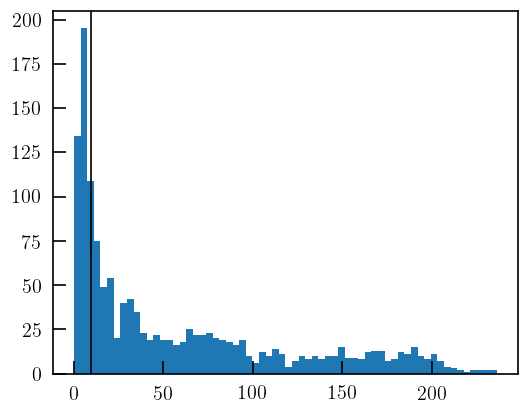

In [6]:
# plt.hist(r_c,np.logspace(-2,2.5,32));
plt.hist(r_c,64);
plt.axvline(10,c='k');
# plt.xscale('log')

In [70]:
np.histogram(r_c, [0,5,10,15,20,1000])

(array([203, 197, 112,  79, 798]), array([   0,    5,   10,   15,   20, 1000]))

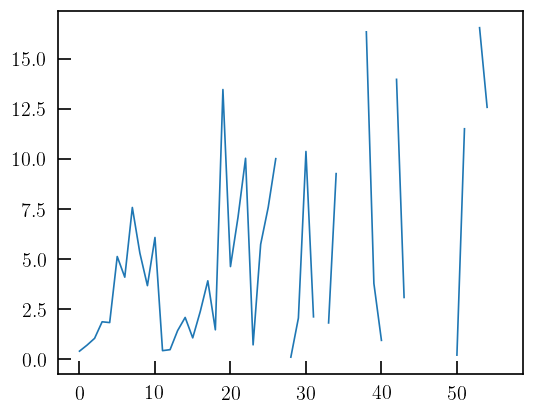

In [68]:
df['r_c'] = r_c
std=df.groupby(pd.cut(df['r_c'],64))[['vx','vy','vz']].std()
plt.plot(std['vz'].values)

(1e-06, 10)

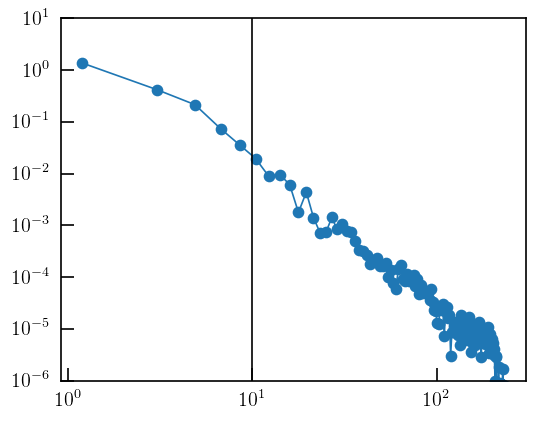

In [56]:
# plt.hist(r_c,np.logspace(-2,2.5,32));
s, be=np.histogram(r_c,128)
bc=(be[1:]+be[:-1])*0.5
plt.plot(bc, s/(np.pi*4*bc**2)/(be[1]-be[0]), 'o-')
plt.axvline(10,c='k');
plt.xscale('log')
plt.ylim(-1,5)
# plt.axhline(0)
plt.yscale('log')
plt.ylim(1e-6,10)

In [14]:
def add_cartesian_xv(df):
    df["x"], df["y"], df["z"] = df.g.icrs.cartesian.xyz.value
    df["vx"], df["vy"], df["vz"] = df.g.icrs.velocity.d_xyz.value
    df["gx"], df["gy"], df["gz"] = df.g.galactic.cartesian.xyz.value
add_cartesian_xv(df)

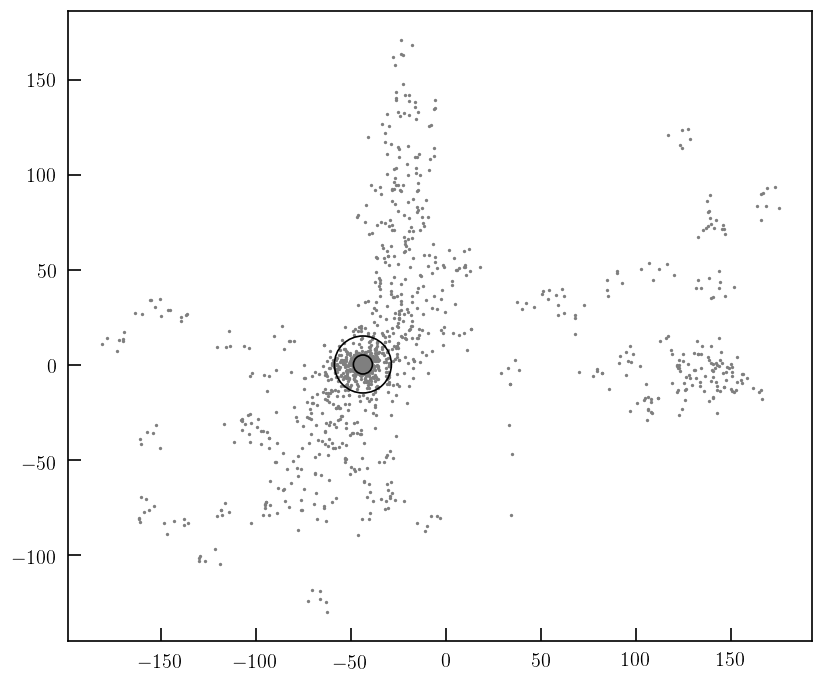

In [73]:
plt.figure(figsize=(8,8))
plt.axes(aspect='equal')
plt.scatter(df['gx'],df['gy'],s=1, c='tab:gray')

from matplotlib.patches import Circle
circle_10pc = Circle([b_c_gal[0],b_c_gal[1]], 10,facecolor='None',edgecolor='k')
circle_5pc = Circle([b_c_gal[0],b_c_gal[1]], 5,facecolor='None',edgecolor='k')
circle_20pc = Circle([b_c_gal[0],b_c_gal[1]], 15,facecolor='None',edgecolor='k')
plt.gca().add_patch(circle_5pc);
# plt.gca().add_patch(circle_10pc);
plt.gca().add_patch(circle_20pc);
# plt.scatter(b_c_gal[0],b_c_gal[1],s=10000,facecolor='',edgecolor='k');

In [ ]:
df.plo

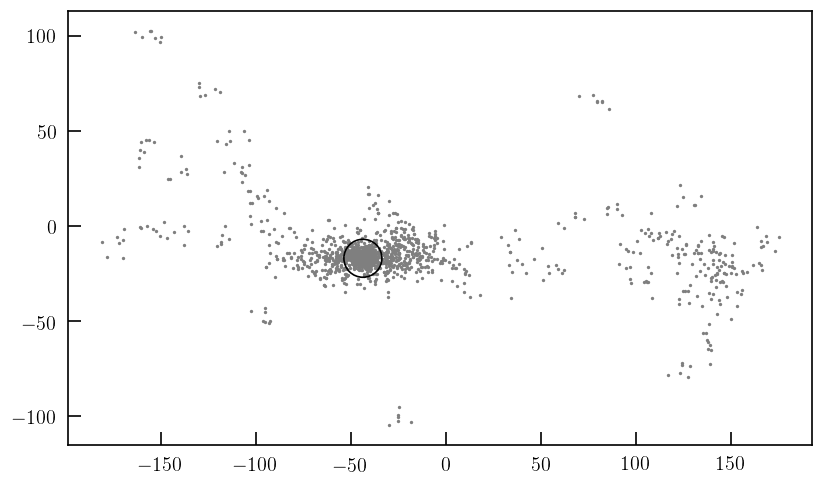

In [45]:
plt.figure(figsize=(8,8))
plt.axes(aspect='equal')
plt.scatter(df['gx'],df['gz'],s=1, c='tab:gray')

from matplotlib.patches import Circle
circle_10pc = Circle([b_c_gal[0],b_c_gal[2]], 10,facecolor='None',edgecolor='k')
plt.gca().add_patch(circle_10pc)
# plt.scatter(b_c_gal[0],b_c_gal[1],s=10000,facecolor='',edgecolor='k');
# plt.axvline(b_c_gal[0]-100)